## Model Development - Gender Detection Model

Importing required libraries

In [36]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers, Model
from keras_preprocessing.image import ImageDataGenerator,img_to_array
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from tensorflow import keras
from keras import regularizers, optimizers
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import imutils
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [7]:
#Reading the DataFrame
df = pd.read_csv("gender_data.csv")

In [8]:
df.head()

,image_id,Male
0,000001.jpg,0
1,000002.jpg,0
2,000005.jpg,0
3,000006.jpg,0
4,000007.jpg,1


In [9]:
#Target Variable in the DataFrame
target_attr = list(df.columns[1:])

Generating the Dataset using the DataGenerator. The dataset size is too large and cannot be loaded into the memory at a time, so DataGenerators load the Data batch-wise.

Note: We are Training this model with 30% margin face-cropped Dataset which we created using the Data Processing Notebook("Data Processing.ipynb")

Note: Here we are using 70000 Images for Training purpose

In [11]:
train_datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)
train_generator=train_datagen.flow_from_dataframe(
    dataframe=new_df[:70000], directory="./Cropped_Data/Train",
    x_col="image_id",
    y_col=target_attr,
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(128,128))

Found 70000 validated image filenames.


Similarly the TestGenerator to load the Validation Data to the model

In [12]:
valid_generator=test_datagen.flow_from_dataframe(
dataframe=df[70000:85000],
directory="./Cropped_Data/Train",
x_col="image_id",
y_col=target_attr,
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(128,128))

Found 15000 validated image filenames.


In [13]:
#Checkpoint - To save the best model while training
checkpoint = ModelCheckpoint('./Cropped_Data/Saved_models/model_male_1-{epoch:03d}-{loss:03f}-{val_loss:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

In [17]:
#Model Architecture

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(128,128,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = "RMSprop",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
#Model Training
step_size_train=train_generator.n//train_generator.batch_size
step_size_valid=valid_generator.n//valid_generator.batch_size
model.fit(train_generator,steps_per_epoch=step_size_train,validation_data=valid_generator,validation_steps=step_size_valid,
          epochs=15,callbacks=[checkpoint])

Epoch 1/15
2187/2187 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.9144
Epoch 00001: val_loss improved from inf to 0.14530, saving model to ./Cropped_Data/Saved_models\model_male_1-001-0.224528-0.145299.h5
2187/2187 [==============================] - 3267s 1s/step - loss: 0.2245 - accuracy: 0.9144 - val_loss: 0.1453 - val_accuracy: 0.9455
Epoch 2/15
2187/2187 [==============================] - ETA: 0s - loss: 0.1203 - accuracy: 0.9563
Epoch 00002: val_loss improved from 0.14530 to 0.09710, saving model to ./Cropped_Data/Saved_models\model_male_1-002-0.120297-0.097099.h5
2187/2187 [==============================] - 3274s 1s/step - loss: 0.1203 - accuracy: 0.9563 - val_loss: 0.0971 - val_accuracy: 0.9644
Epoch 3/15
1119/2187 [==============>...............] - ETA: 25:55 - loss: 0.1107 - accuracy: 0.9600

In [14]:
#Loading the best model
model = tf.keras.models.load_model("./Cropped_Data/Saved_models/model_male_1-002-0.120297-0.097099.h5")

In [ ]:
#Saving the weights of the best model
model.save_weights("./weights_gender.h5")

### Testing of the Model

Helper function which takes the path of an Image and predicts whether a person is Male or Female.

In [51]:
def predict_gender(source):
    image = cv2.imread(source,1)
    image = imutils.resize(image, width=200)
    I_H,I_W,I_C = image.shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.2,10,minSize=(50,50))
    p = 0.30
    idx=0
    cropped_image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(cropped_image)
    plt.show()
    if(len(faces)==0):
            print("FaceNotFound")
    else:
        max_area = 0
        for i in range(len(faces)):
            x, y, w, h = faces[i]
            if (w*h > max_area):
                max_area = w*h
                idx = i
        if(max_area<=400):
            print("NotFound")
        X, Y, w, h = faces[idx]
        y1 = max(0,Y - int(p*h))
        y2 = min((Y+h) + int(p*h), I_H)
        x1 = max(0,X - int(w*p))
        x2 = min(X+w + int(p*w), I_W)
        cropped_image = cropped_image[y1:y2, x1:x2]
        cropped_image = cv2.resize(cropped_image, (128, 128))
        array = img_to_array(cropped_image)
        array = array/255.0
        arr = np.reshape(array,(128,128,3))
        out = model.predict(np.array([array]))[0][0]
        if(out<0.5):
            print("Prediction: Female")
        else:
            print("Prediction: Male")

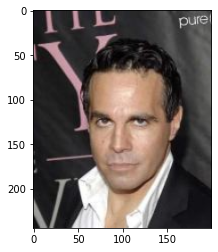

Prediction: Male


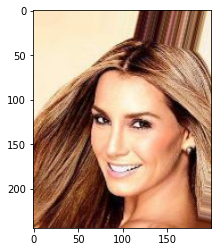

Prediction: Female


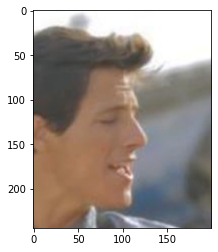

FaceNotFound


In [52]:
predict_gender("./img_align_celeba//img_align_celeba//000008.jpg")
predict_gender("./img_align_celeba//img_align_celeba//000001.jpg")
predict_gender("./img_align_celeba//img_align_celeba//000003.jpg")